In [76]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, DenseFeatures, Lambda, Add, Dot, Activation, Layer
from tensorflow.keras import Model
from tensorflow.keras.initializers import GlorotNormal
from Layer_FM import Layer_FM
import numpy as np

In [77]:
from utils.conf_process import myconfigparser
from utils.feature_process import tuple_feature_process
from utils.active_method import activate
from utils.optimizer_method import get_optimizer
from utils.distribut_conf import set_dist_env

In [78]:
EMBEDDING_SIZE = 8
HIDDEN_UNITS = [32, 8]
BATCH_SIZE = 4

In [79]:
def build_model_columns(conf_path):

    deep_columns = list()
    sparse_cols = []
    dense_cols = []

    sparse_col_names = []
    dense_col_names = []

    default_dict = {}
    embedding_nums = 0

    cfg = myconfigparser()
    cfg.read(conf_path)
    sections = cfg.sections()

    for part_key in sections:

        items_lst = cfg.items(part_key)

        if part_key == "deep":
            for items in items_lst:
                feature_name = items[0].strip()
                feature_col,default_val,embedding_num = tuple_feature_process(items,int(EMBEDDING_SIZE))
                embedding_nums += embedding_num
                if feature_name not in default_dict:
                    default_dict[feature_name] = default_val
                deep_columns.append(feature_col)
                # if isinstance(feature_col, tf.feature_column.indicator_column):
                #     sparse_cols.append(feature_col)
                #     sparse_col_names.append(feature_name)
                # else:
                #     dense_cols.append(feature_col)
                #     dense_col_names.append(feature_name)

    #获取所有特征列(cfg取出的格式为[(特征名，具体值)])
    columns = cfg.items("use")[0][1].strip().split(",")
    sparse_cols_names = cfg.items("sparse_feature")[0][1].strip().split(",")
    numeric_cols_names = cfg.items("numeric_feature")[0][1].strip().split(",")
    default_dict["label"] = 0
    cols_default = list(map(lambda x:["-1"] if x not in default_dict else [default_dict[x]], columns))
    return deep_columns, columns, cols_default,embedding_nums, sparse_cols_names, numeric_cols_names

In [80]:
deep_columns, columns, cols_default, embedding_num, sparse_cols_names, numeric_cols_names = build_model_columns('data/feature_engineering.conf')

## Split sparse and numeric feature columns

In [81]:

sparse_feature_cols = filter(lambda col: col.name.split('_indicator')[0] in sparse_cols_names, deep_columns)
numeric_feature_cols = filter(lambda col: col.name in numeric_cols_names, deep_columns)
sparse_feature_cols = list(sparse_feature_cols)
numeric_feature_cols = list(numeric_feature_cols)
print(sparse_feature_cols)
print(numeric_feature_cols)

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sp_feat1', vocabulary_list=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14'), dtype=tf.string, default_value=-1, num_oov_buckets=1)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sp_feat2', vocabulary_list=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14'), dtype=tf.string, default_value=-1, num_oov_buckets=1)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sp_feat3', vocabulary_list=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'), dtype=tf.string, default_value=-1, num_oov_buckets=1)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sp_feat4', vocabulary_list=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19'), dtype=tf.string, default_value=-1, num_oov_buckets=1))]
[NumericColumn(key='num_fea

## Generate dataset from csv

In [82]:
LABEL_COLUMN = 'label'
def get_dataset(file_path, **kwargs):
  dataset = tf.data.experimental.make_csv_dataset(
      file_path,
      batch_size=5, # Artificially small to make examples easier to show.
      label_name=LABEL_COLUMN,
      na_value="?",
      num_epochs=1,
      ignore_errors=True,
      **kwargs)
  return dataset

In [83]:
raw_train_data = get_dataset('data/train.data.csv', column_names=columns)

In [84]:
def show_batch(dataset):
  
  for batch, label in dataset.take(1):
    for key, value in batch.items():
      print("{:20s}: {}".format(key,value.numpy()))

In [65]:
show_batch(raw_train_data)

sp_feat1            : [2 3 2 6 1]
sp_feat2            : [2 1 1 1 0]
sp_feat3            : [1 1 1 1 1]
num_feat1           : [ 4000. 15000.  2500.   500.  1060.]
sp_feat4            : [5 7 4 0 2]
num_feat2           : [100. 103.  92.  12.  18.]
DSarearange         : [3 3 3 0 0]
DSfirsttime_rent    : [0 0 0 0 0]
DSallfloor          : [24 33 32 13 25]
DSfloor             : [12 19 26 12 19]
DSrenovation        : [6 2 4 2 4]
DSnear_subway       : [0 0 0 0 0]
DSanxuan            : [-1 -1 -1  1 -1]
DScommunity         : [100665564 100684411 100084597 102281468 100384486]
DSfacility_num      : [19 11 19  6  9]
DSfine_decorated    : [0 0 1 0 1]
DSpicnum            : [8 9 7 3 4]
DSunitprice         : [ 40.       145.63107   27.173914  41.666668  58.88889 ]
HCtagsfhgectrap     : [0.3552     0.19440906 0.31738326 0.31138402 0.33543953]
HCVRtagsfhgecvrap   : [0.0524     0.03060382 0.0524     0.05158185 0.04829008]
RCrctr              : [229 124 218  18 226]


In [66]:
sparse_train_data = get_dataset('data/train.data.csv', column_names=columns,select_columns=sparse_cols_names.copy()) # use copy to avoid make_csv_dataset changes the select_columns from str list to index list
numeric_train_data = get_dataset('data/train.data.csv', column_names=columns,select_columns=numeric_cols_names.copy())
show_batch(sparse_train_data)
print()
show_batch(numeric_train_data)

sp_feat1            : [2 2 1 4 2]
sp_feat2            : [2 1 1 2 1]
sp_feat3            : [1 1 1 2 1]
sp_feat4            : [3 3 2 3 5]

num_feat1           : [2000. 1789.  850.  900. 1400.]
num_feat2           : [ 43.  48.  30.  58. 100.]


## 

In [67]:
sp_feature_names = sparse_cols_names.copy()
sp_feature_names.remove('label')
sp_feature_names

['sp_feat1', 'sp_feat2', 'sp_feat3', 'sp_feat4']

In [68]:
num_feature_names = numeric_cols_names.copy()
num_feature_names.remove('label')
num_feature_names

['num_feat1', 'num_feat2']

In [69]:
sparse_train_batch, labels_batch = next(iter(sparse_train_data))

In [70]:
sparse_train_batch

OrderedDict([('sp_feat1',
              <tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 1, 3, 1, 2], dtype=int32)>),
             ('sp_feat2',
              <tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 1, 1, 1, 2], dtype=int32)>),
             ('sp_feat3',
              <tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 1, 1, 2, 1], dtype=int32)>),
             ('sp_feat4',
              <tf.Tensor: shape=(5,), dtype=int32, numpy=array([5, 3, 4, 2, 2], dtype=int32)>)])

## Customize FM layer

## Generate Inputs Layer

In [71]:
sp_features_len = len(sp_feature_names)
num_features_len = len(num_feature_names)
print(sp_features_len)
print(num_features_len)

4
2


In [72]:
sparse_inputs = {
    colname : tf.keras.layers.Input(shape=(), name=colname, dtype=tf.string, sparse=True) for colname in sp_feature_names
}
numeric_inputs = {
    colname : tf.keras.layers.Input(shape=(), name=colname, dtype='float32', sparse=False) for colname in num_feature_names
}
print(sparse_inputs)
print(numeric_inputs)

{'sp_feat1': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x142e6f0d0>, 'sp_feat2': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x144792990>, 'sp_feat3': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x1447e52d0>, 'sp_feat4': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x1447e5350>}
{'num_feat1': <tf.Tensor 'num_feat1_2:0' shape=(None,) dtype=float32>, 'num_feat2': <tf.Tensor 'num_feat2_2:0' shape=(None,) dtype=float32>}


## Model Definition

In [75]:
sp_dense = DenseFeatures(sparse_feature_cols, name='sparse_input_layer')(sparse_inputs)
num_dense = DenseFeatures(numeric_feature_cols, name='numeric_input_layer')(numeric_inputs)

#---linear---
both = tf.keras.layers.concatenate([sp_dense, num_dense], name='both')
first_order = Dense(1, input_shape=both.shape, name='first_order')(both)

#---fm---
fm_inputs = {'sparse': sp_dense, 'numeric': num_dense}
second_order, v_em = Layer_FM(sp_features_len, num_features_len, EMBEDDING_SIZE, name='FM')(fm_inputs)

# ---deep---
field_size = sp_features_len + num_features_len
deep_inputs = tf.reshape(v_em, shape=(-1, field_size*EMBEDDING_SIZE))
for layer_id, num_hidden_units in enumerate(HIDDEN_UNITS):
    layer_name = 'deep_%d'%(layer_id)
    deep_inputs = Dense(num_hidden_units, activation='relu', kernel_initializer=GlorotNormal(), name=layer_name)(deep_inputs)
y_deep = Dense(1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2)(deep_inputs)

outputs = first_order+second_order+y_deep

outputs = Activation('sigmoid')(outputs)
model = Model([sparse_inputs, numeric_inputs], outputs)


TypeError: 'module' object is not callable

In [53]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sp_feat1 (InputLayer)           [(None,)]            0                                            
__________________________________________________________________________________________________
sp_feat2 (InputLayer)           [(None,)]            0                                            
__________________________________________________________________________________________________
sp_feat3 (InputLayer)           [(None,)]            0                                            
__________________________________________________________________________________________________
sp_feat4 (InputLayer)           [(None,)]            0                                            
______________________________________________________________________________________________

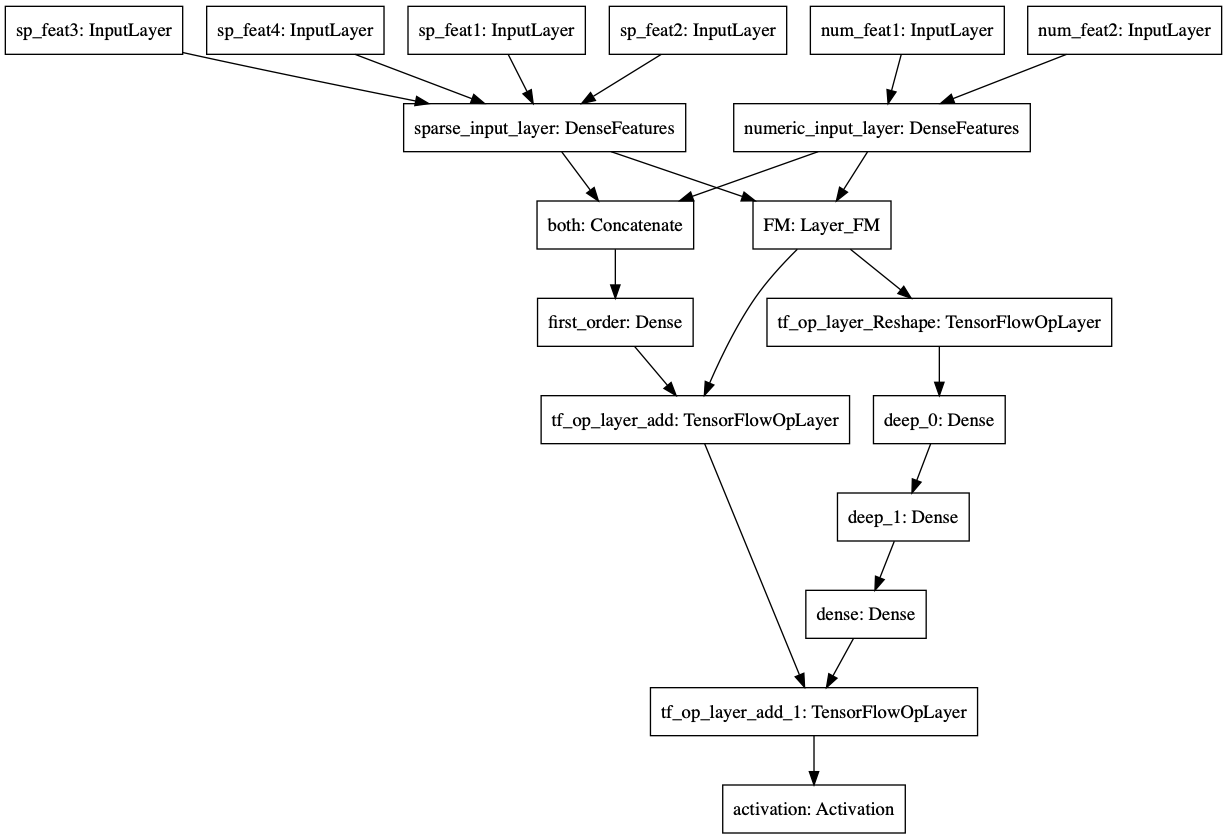

In [54]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')